In [2]:
%pip install "stellargraph[igraph]" chardet -Uq
# %conda install cairocffi

Note: you may need to restart the kernel to use updated packages.


In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import stellargraph as sg
from stellargraph.data import UniformRandomMetaPathWalk
import igraph as ig

2021-11-11 12:37:21.427144: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [114]:
from sklearn.metrics.pairwise import cosine_similarity

H = pd.read_csv('models/cogtext/H_USEv4_UMAP5d_v1.csv.gz')
H = H.set_index(['category','label'])#.reset_index()

from sklearn.preprocessing import Normalizer
H.iloc[:,:] = Normalizer(norm='l1').fit_transform(H)

In [174]:
# cooc: tasks = data.groupby('task')['task_corpus_size'].apply(lambda x: x.iloc[0]).rename('corpus_size').to_frame()
# constructs = data.groupby('construct')['construct_corpus_size'].apply(lambda x: x.iloc[0]).rename('corpus_size').to_frame()
# edges = data[['construct','task','jaccard_coefficient']]
# edges.columns = ['source', 'target', 'weight']

tasks = H.reset_index().query('category == "CognitiveTask"').set_index(['category','label']).reset_index(0,drop=True)
constructs = H.reset_index().query('category == "CognitiveConstruct"').set_index(['category','label']).reset_index(0,drop=True)

H_sim = pd.DataFrame(cosine_similarity(H), index=H.index.levels[1], columns=H.index.levels[1])
H_sim = H_sim.unstack()
H_sim.index.set_names(['source','target'], inplace=True)
H_sim = H_sim.reset_index().rename({0: 'weight'}, axis=1)

edges = H_sim.query('weight > .8')

# edges = edges.query('weight > 0.001')

G = sg.StellarGraph({'task': tasks, 'construct': constructs}, edges=edges)
print(G.info())

# import networkx as nx
# ig.plot(ig.Graph.from_networkx(G.to_networkx()))
# nx.draw_spring(G.to_networkx())


StellarGraph: Undirected multigraph
 Nodes: 172, Edges: 8304

 Node types:
  task: [100]
    Features: float32 vector, length 234
    Edge types: task-default->construct, task-default->task
  construct: [72]
    Features: float32 vector, length 234
    Edge types: construct-default->construct, construct-default->task

 Edge types:
    construct-default->task: [4002]
        Weights: range=[0.800208, 0.998232], mean=0.899659, std=0.053345
        Features: none
    task-default->task: [2388]
        Weights: range=[0.800001, 1], mean=0.906512, std=0.060447
        Features: none
    construct-default->construct: [1914]
        Weights: range=[0.800374, 1], mean=0.902927, std=0.0555441
        Features: none


In [175]:
# metapath2vec

rnd_walk_length = 5  # maximum length of a random walk

# metapath schemas as a list of lists of node types.
metapaths = [
    ['task', 'construct', 'task'],
    ['construct', 'task', 'construct'],
    # ['construct', 'task', 'task', 'construct'],
    # ['task', 'construct', 'task', 'construct', 'task'],
    # ['task', 'construct', 'construct', 'task'],
]

rw = UniformRandomMetaPathWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=rnd_walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)

print(f'Number of random walks: {len(walks)}')

[w for w in walks if w[0] == 'Attention']

Number of random walks: 1720


[['Attention', 'Go_NoGo', 'Creativity', 'StimSSS', 'Binding'],
 ['Attention',
  'Cued_Unpredictable_Switch_task',
  'FluidIntelligence',
  'Stroop',
  'CognitiveFlexibility'],
 ['Attention',
  'RecentProbesTask',
  'LongTermMemory',
  'OSpan_-_Operating_Span',
  'ResponseInhibition'],
 ['Attention',
  'AttentionNetworkTest',
  'InhibitoryControl',
  'AuditoryAttentionTask',
  'LongTermMemory'],
 ['Attention',
  'Dimension-switching_task',
  'ShortTermMemory',
  'CognitiveReflectionTest',
  'LogicalReasoning'],
 ['Attention',
  'Hayling_test',
  'ResponseConflict',
  'StopSignalTask',
  'StrategicRetrieval'],
 ['Attention',
  'StopSignalTask',
  'ContextProcessing',
  'AnalogyMakingTask',
  'Binding'],
 ['Attention',
  'AuditoryAttentionTask',
  'RelationalReasoning',
  'Object_Substitution_task',
  'DeductiveReasoning'],
 ['Attention',
  'OSpan_-_Operating_Span',
  'EpisodicMemory',
  'Object_Substitution_task',
  'ExplicitMemory'],
 ['Attention',
  'NBackTask',
  'Organization',
  'At

In [187]:
from gensim.models import Word2Vec

model = Word2Vec(walks, vector_size=256, window=5, sg=1, workers=2, epochs=1000)
print('shape:', model.wv.vectors.shape)

shape: (172, 256)


In [198]:
print('Most similar nodes to `Stroop` and `ExecutiveFunction`')

model.wv.most_similar(['BART','ExecutiveFunction'])
# model.wv.most_similar('Semantic_Fluency_test')

Most similar nodes to `Stroop` and `ExecutiveFunction`


[('DiscountingTask', 0.7716186046600342),
 ('ColumbiaCardTask', 0.7540881633758545),
 ('Delay_Discounting_task', 0.7492749691009521),
 ('RewardProcessing', 0.721710741519928),
 ('SnackDelayTask', 0.5534384250640869),
 ('SelfRegulation', 0.5496988296508789),
 ('ReversalLearning', 0.5488037467002869),
 ('BehavioralRegulation', 0.5445582866668701),
 ('GiftWrap', 0.540074348449707),
 ('EffortfulControl', 0.535616397857666)]

In [217]:
%pip install fastcluster

     |████████████████████████████████| 173 kB 1.4 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  ERROR: Command errored out with exit status 1:
   command: /usr/local/Caskroom/miniforge/base/envs/py38/bin/python /usr/local/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/pip/_vendor/pep517/in_process/_in_process.py build_wheel /var/folders/3_/gmvd1nkx285133z5yh3chz2c0000gp/T/tmpu8ln1u2u
       cwd: /private/var/folders/3_/gmvd1nkx285133z5yh3chz2c0000gp/T/pip-install-n2d431k_/fastcluster_9488c3655dc44ebf870fa62ba619687e
  Complete output (16 lines):
  Fastcluster version: 1.2.4
  Python version: 3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:50:56)
  [Clang 11.1.0 ]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.9-x86_64-3.8
  copying fastcluster.py -> build/lib.macosx-10.9-x86_64-3.8
  running bu

/usr/local/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


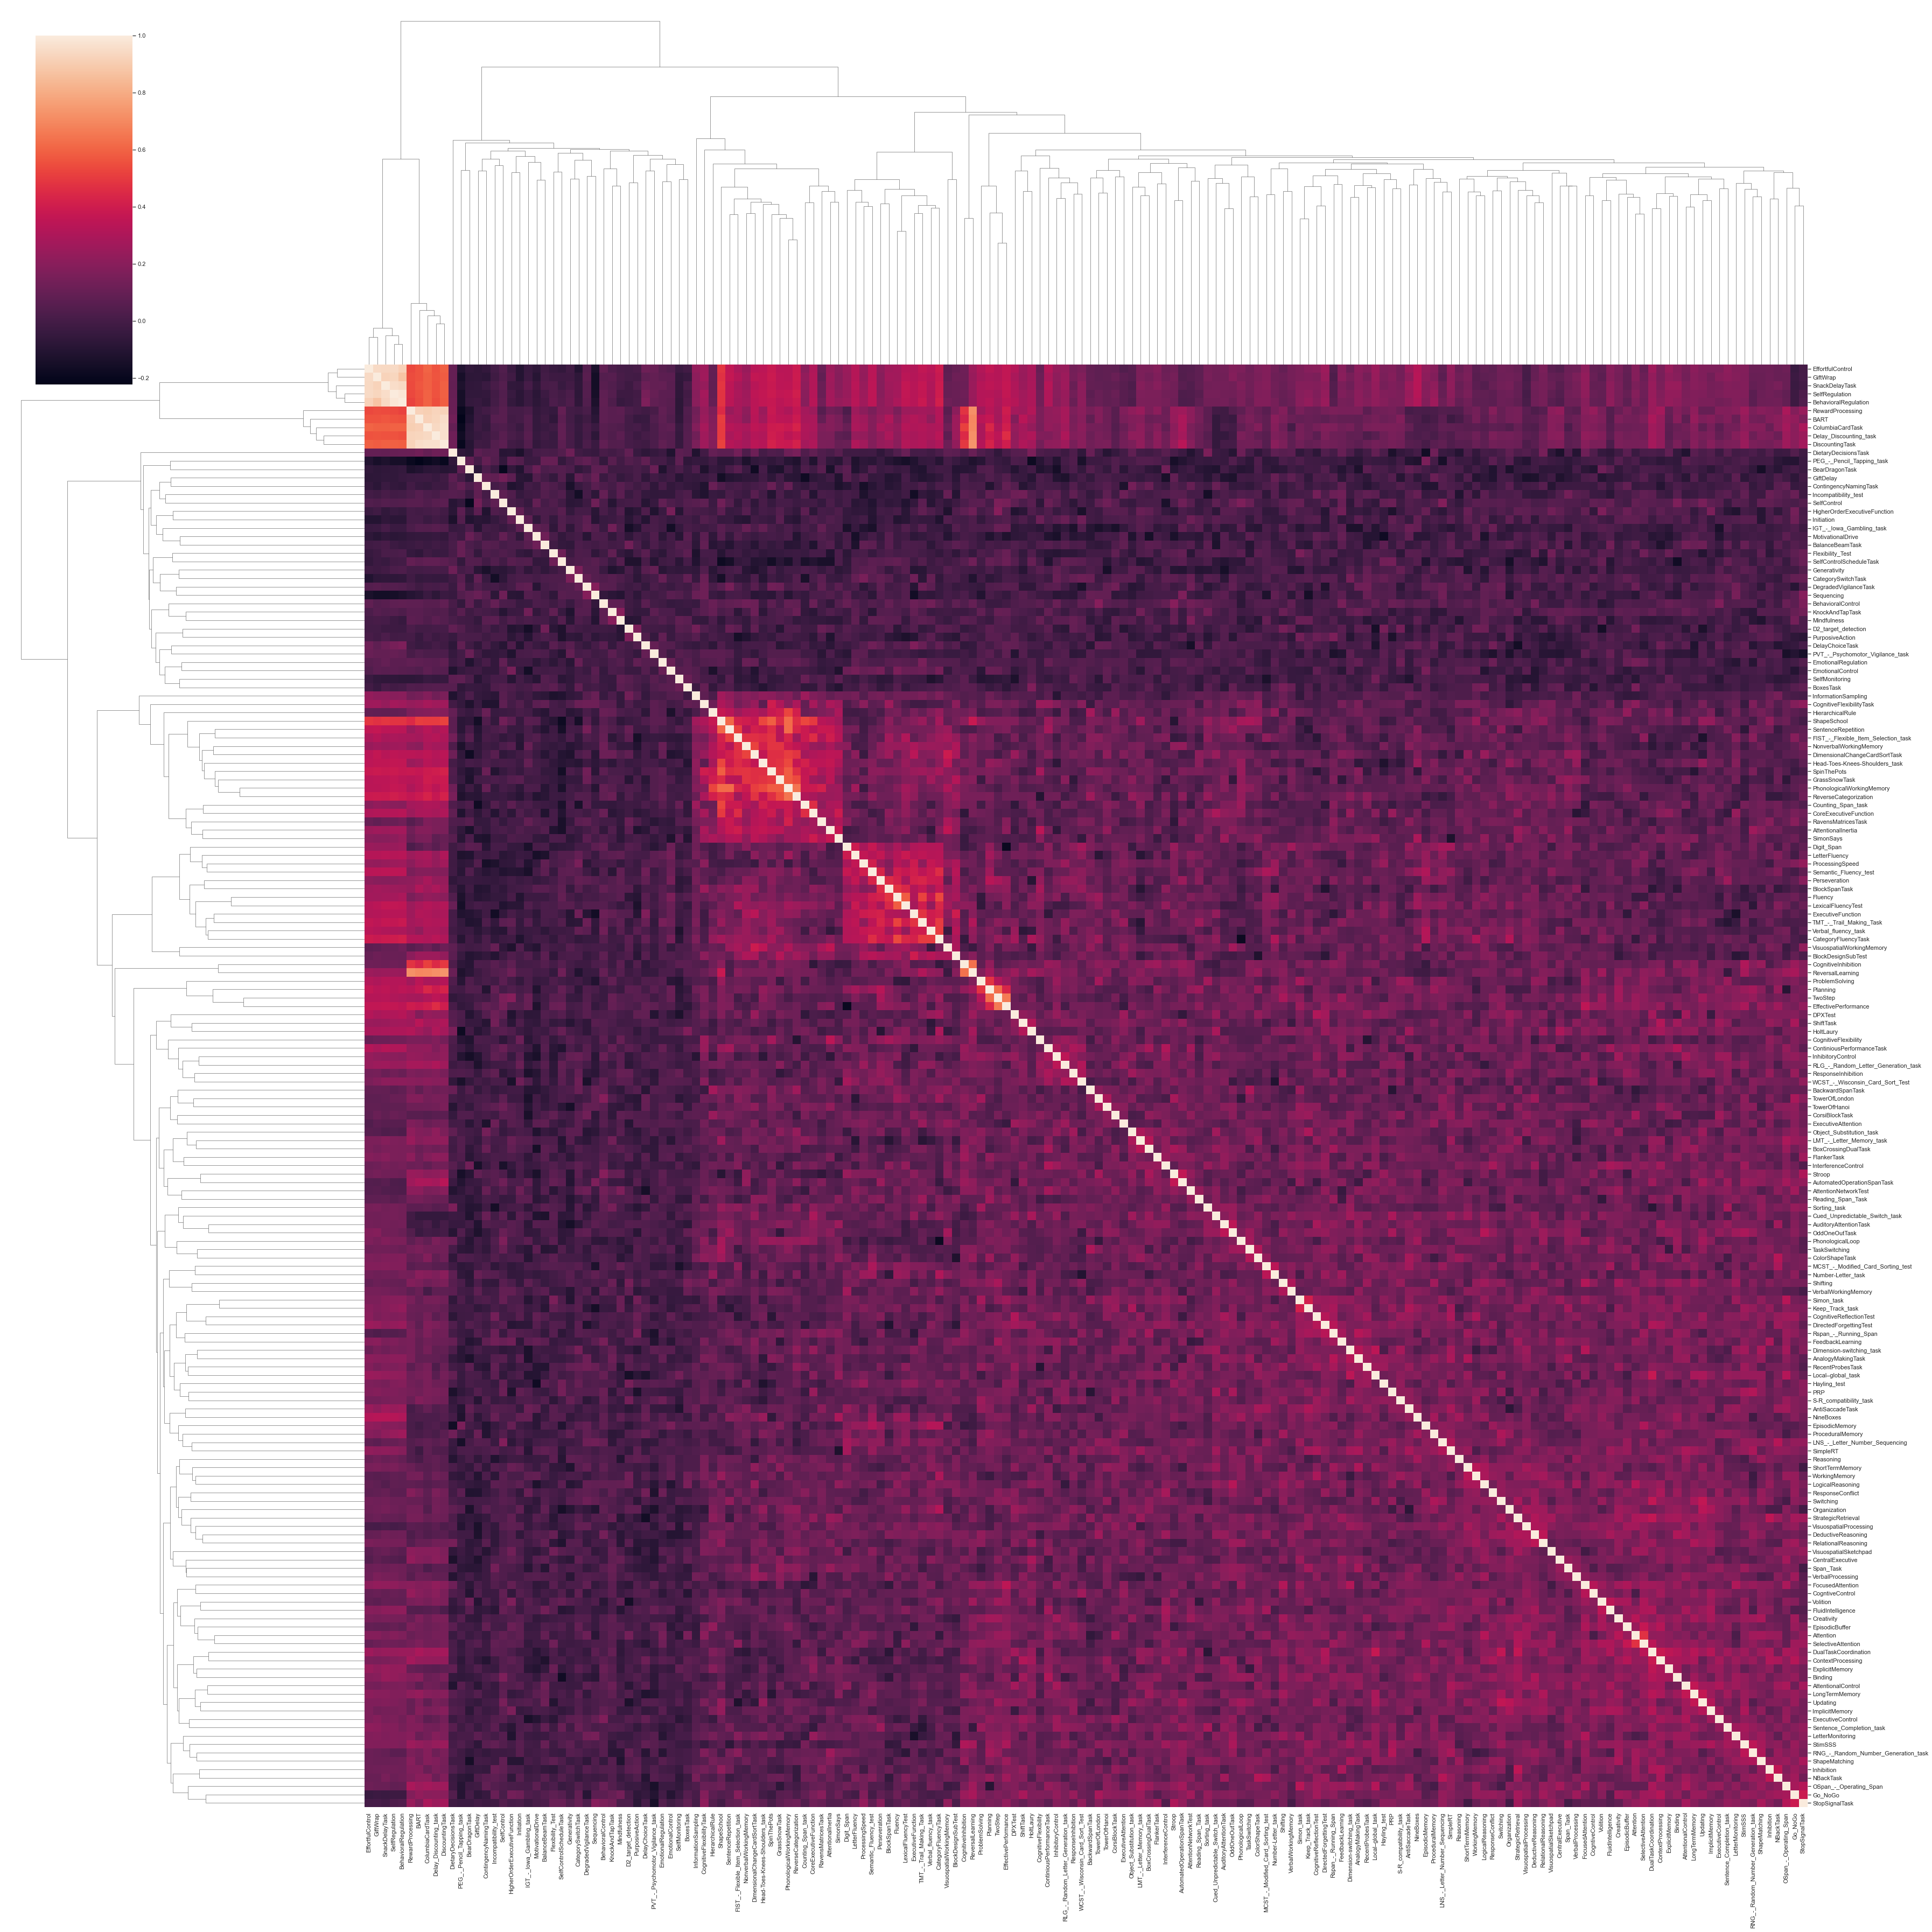

In [218]:
G_v = pd.DataFrame(model.wv.vectors, index=model.wv.index_to_key)
G_sim = cosine_similarity(G_v)
G_sim = pd.DataFrame(G_sim, index=G_v.index, columns=G_v.index)
import seaborn as sns
sns.clustermap(G_sim, figsize=(50,50))

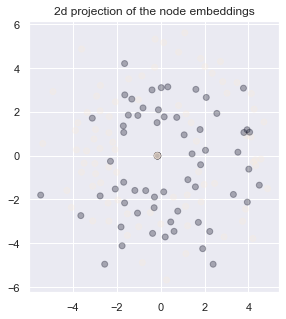

In [183]:
# viz

node_embeddings = model.wv.vectors
node_types = [G.node_type(node_id) for node_id in model.wv.index_to_key]

from sklearn.manifold import MDS
import numpy as np
import matplotlib.pyplot as plt


node_embeddings_2d = MDS(n_components=2, metric='cosine').fit_transform(node_embeddings)

label_map = {l: i for i, l in enumerate(np.unique(node_types))}
node_colors = [label_map[t] for t in node_types]

plt.figure(figsize=(5, 5))
plt.axes().set(aspect='equal')
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=node_colors, alpha=0.3)
plt.title('2d projection of the node embeddings')
plt.show()